In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import os

In [2]:
# Set random seed for reproducibility
np.random.seed(0)

In [3]:
# SPARQL endpoint for DBpedia
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

In [4]:
# Function to fetch triples with pagination
def fetch_triples(limit=10000, max_results=500000):
    triples = []
    offset = 0
    while offset < max_results:
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT ?movie ?title ?director ?releaseDate ?genre ?actor ?producer  ?distributor
            WHERE {{
                ?movie a dbo:Film .
                ?movie rdfs:label ?title .
                FILTER (lang(?title) = 'en')
                OPTIONAL {{ ?movie dbo:director ?director . }}
                OPTIONAL {{ ?movie dbo:releaseDate ?releaseDate . }}
                OPTIONAL {{ ?movie dbo:genre ?genre . }}
                OPTIONAL {{ ?movie dbo:starring ?actor . }}
                OPTIONAL {{ ?movie dbo:producer ?producer . }}
                OPTIONAL {{ ?movie dbo:distributor ?distributor . }}

            }}
            LIMIT {limit} OFFSET {offset}
        """
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        try:
            results = sparql.query().convert()
            new_triples = [
                (
                    result["movie"]["value"],
                    result["title"]["value"],
                    result.get("director", {}).get("value", ""),
                    result.get("releaseDate", {}).get("value", ""),
                    result.get("genre", {}).get("value", ""),
                    result.get("actor", {}).get("value", ""),
                    result.get("producer", {}).get("value", ""),
                    result.get("distributor", {}).get("value", "")
                )
                for result in results["results"]["bindings"]
            ]
            if not new_triples:
                break
            triples.extend(new_triples)
            print(f"Retrieved {len(new_triples)} triples at offset {offset}. Total: {len(triples)}")
            offset += limit
            if len(new_triples) < limit:
                break
        except Exception as e:
            print(f"Error at offset {offset}: {e}")
            break
    return triples

In [5]:
# Fetch triples
triples = fetch_triples(limit=10000, max_results=500000)
# save_triples_to_nt(triples, "dbp" \
# "edia_movies_raw.nt")
print(f"Total retrieved triples: {len(triples)}")
print("First 5 triples:", triples[:5])

Retrieved 10000 triples at offset 0. Total: 10000
Retrieved 10000 triples at offset 10000. Total: 20000
Retrieved 10000 triples at offset 20000. Total: 30000
Retrieved 10000 triples at offset 30000. Total: 40000
Retrieved 10000 triples at offset 40000. Total: 50000
Retrieved 10000 triples at offset 50000. Total: 60000
Retrieved 10000 triples at offset 60000. Total: 70000
Retrieved 10000 triples at offset 70000. Total: 80000
Retrieved 10000 triples at offset 80000. Total: 90000
Retrieved 10000 triples at offset 90000. Total: 100000
Retrieved 10000 triples at offset 100000. Total: 110000
Retrieved 10000 triples at offset 110000. Total: 120000
Retrieved 10000 triples at offset 120000. Total: 130000
Retrieved 10000 triples at offset 130000. Total: 140000
Retrieved 10000 triples at offset 140000. Total: 150000
Retrieved 10000 triples at offset 150000. Total: 160000
Retrieved 10000 triples at offset 160000. Total: 170000
Retrieved 10000 triples at offset 170000. Total: 180000
Retrieved 10000

In [110]:
# Convert to dictionary
data = {}
for movie, title, director, release_date, genre, actor,producer,distributor in triples:
    if movie not in data:
        data[movie] = {
            "title": title,
            "director": director,
            "release_date": release_date,
            "genre": genre,
            "actor": actor,
            "producer": producer,
            "distributor": distributor
        }
    else:
        if genre and genre not in data[movie]["genre"]:
            data[movie]["genre"] += f";{genre}" if data[movie]["genre"] else genre
        if actor and actor not in data[movie]["actor"]:
            data[movie]["actor"] += f";{actor}" if data[movie]["actor"] else actor
        if director and director not in data[movie]["director"]:
            data[movie]["director"] += f";{director}" if data[movie]["director"] else director
        
        if producer and producer not in data[movie]["producer"]:
            data[movie]["producer"] += f";{producer}" if data[movie]["producer"] else producer
        
        if distributor and distributor not in data[movie]["distributor"]:
            data[movie]["distributor"] += f";{distributor}" if data[movie]["distributor"] else distributor

In [111]:
print(f"Data dictionary created with {len(data)} unique movies.")
print("Sample data from the dictionary:")
for key, value in list(data.items())[:5]:
    print(f"{key}: {value}")

Data dictionary created with 109504 unique movies.
Sample data from the dictionary:
http://dbpedia.org/resource/Cabin_by_the_Lake: {'title': 'Cabin by the Lake', 'director': 'http://dbpedia.org/resource/Po-Chih_Leong', 'release_date': '', 'genre': 'http://dbpedia.org/resource/Horror_film', 'actor': 'http://dbpedia.org/resource/Judd_Nelson;http://dbpedia.org/resource/Hedy_Burress;http://dbpedia.org/resource/Michael_Weatherly', 'producer': 'http://dbpedia.org/resource/Judith_Craig_Marlin;http://dbpedia.org/resource/John_V._Stuckmeyer', 'distributor': 'http://dbpedia.org/resource/USA_Network'}
http://dbpedia.org/resource/Cage_Without_a_Key: {'title': 'Cage Without a Key', 'director': 'http://dbpedia.org/resource/Buzz_Kulik', 'release_date': '', 'genre': 'http://dbpedia.org/resource/Drama_(film_and_television)', 'actor': "http://dbpedia.org/resource/Lani_O'Grady;http://dbpedia.org/resource/Katherine_Helmond;http://dbpedia.org/resource/Susan_Dey;http://dbpedia.org/resource/Anne_Bloom;http:/

In [112]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna('')
print("DataFrame created from DBpedia movie data:")
print(df.head())
len(df)

DataFrame created from DBpedia movie data:
                                                                          title  \
http://dbpedia.org/resource/Cabin_by_the_Lake                 Cabin by the Lake   
http://dbpedia.org/resource/Cage_Without_a_Key               Cage Without a Key   
http://dbpedia.org/resource/Caddie_(film)                         Caddie (film)   
http://dbpedia.org/resource/Caesar_and_Cleopatr...  Caesar and Cleopatra (film)   
http://dbpedia.org/resource/Calendar_(1993_film)           Calendar (1993 film)   

                                                                                      director  \
http://dbpedia.org/resource/Cabin_by_the_Lake        http://dbpedia.org/resource/Po-Chih_Leong   
http://dbpedia.org/resource/Cage_Without_a_Key          http://dbpedia.org/resource/Buzz_Kulik   
http://dbpedia.org/resource/Caddie_(film)           http://dbpedia.org/resource/Donald_Crombie   
http://dbpedia.org/resource/Caesar_and_Cleopatr...  http://dbpedia

109504

In [113]:
# Simplify column names and values
df.index = df.index.str.split("/").str[-1]
for col in df.columns:
    df[col] = df[col].str.split("/").str[-1]
    df[col] = df[col].str.split("#").str[-1]

In [114]:
print(df.head())
len(df)

                                                   title        director  \
Cabin_by_the_Lake                      Cabin by the Lake   Po-Chih_Leong   
Cage_Without_a_Key                    Cage Without a Key      Buzz_Kulik   
Caddie_(film)                              Caddie (film)  Donald_Crombie   
Caesar_and_Cleopatra_(film)  Caesar and Cleopatra (film)  Gabriel_Pascal   
Calendar_(1993_film)                Calendar (1993 film)     Atom_Egoyan   

                            release_date                        genre  \
Cabin_by_the_Lake                                         Horror_film   
Cage_Without_a_Key                        Drama_(film_and_television)   
Caddie_(film)                 1976-04-01                                
Caesar_and_Cleopatra_(film)   1945-12-11                                
Calendar_(1993_film)          1993-06-03                                

                                         actor            producer  \
Cabin_by_the_Lake            Micha

109504

In [115]:
# Print missing values
print("\nMissing values before filtering:")
print(df[['director', 'release_date', 'genre', 'actor', 'producer','distributor']].isna().sum())


Missing values before filtering:
director        0
release_date    0
genre           0
actor           0
producer        0
distributor     0
dtype: int64


In [116]:
# Debug: Printing unique genres before filtering
print("\nUnique genres before filtering:")
print(df['genre'].str.split(';').explode().value_counts())


Unique genres before filtering:
genre
                               108373
Sitcom                             76
Drama_(film_and_television)        57
Comedy                             55
Telenovela                         49
                                ...  
Sci-Fi                              1
Teen                                1
Factual_television                  1
Historical_Drama                    1
Restoration_comedy                  1
Name: count, Length: 268, dtype: int64


In [117]:
# Filtering genre labels
df['genre'] = df['genre'].str.lower().replace({
    # COMEDY
    'comedy_film': 'comedy',
    'romantic_comedy': 'comedy',
    'comedy-drama': 'comedy',
    'dramedy': 'comedy',
    'romantic_comedy_film': 'comedy',
    'sitcom': 'comedy',
    
    # DRAMA
    'drama_film': 'drama',
    'romance_film': 'drama',
    'romantic_drama': 'drama',
    'telenovela': 'drama',
    'dramatic_programming': 'drama',
    'romantic_drama_film': 'drama',
    'romantic_drama_television': 'drama',
    'romantic_drama_television_series': 'drama',
    'romantic_drama_television_show': 'drama',
    'drama_(film_and_television)': 'drama',
    'soap_opera': 'drama',
    'period_drama': 'drama',
    'docudrama': 'drama',
    'historical_drama': 'drama',
    'costume_drama': 'drama',
    'serial_(radio_and_television)': 'drama',
    'serial_drama': 'drama',
    'medical_drama': 'drama',
    'crime_drama': 'drama',
    'political_drama': 'drama',
    'legal_drama': 'drama',
    'teen_drama': 'drama',
    'dramas': 'drama',
    'drama_documentary': 'drama',
    'melodrama': 'drama',
    'miniseries': 'drama',
    'anthology_series': 'drama',
    'slice_of_life': 'drama',
}, regex=False)

In [118]:
# Debug: Printing unique genres after filtering
print("\nUnique genres after filtering:")
print(df['genre'].str.split(';').explode().value_counts())
#put output in csv file
#df['genre'].str.split(';').explode().value_counts().to_csv('unique_genres.csv', header=True)


Unique genres after filtering:
genre
                      108373
drama                    282
comedy                   159
documentary_film          36
horror_film               30
                       ...  
russian_symbolism          1
film_trailers              1
classic                    1
teen                       1
factual_television         1
Name: count, Length: 237, dtype: int64


In [119]:
# Filter for comedy or drama
def filter_genres(genre_string):
    if not genre_string:
        return False
    genres = genre_string.split(';')
    for g in genres:
        if 'comedy' in g or 'drama' in g:
            return True
    return False

In [120]:
df = df[df['genre'].apply(filter_genres)]

In [121]:
# Assign labels
df['label'] = df['genre'].apply(lambda x: 'comedy' if 'comedy' in x else 'drama')

In [122]:
# Filling missing values
df['director'] = df['director'].replace('', 'Unknown')
df['release_date'] = df['release_date'].fillna('Unknown')
df['actor'] = df['actor'].replace('', 'Unknown')
df['producer'] = df['producer'].replace('', 'Unknown')
df['distributor'] = df['distributor'].replace('', 'Unknown')

In [123]:
# Droping rows with empty genres
df = df[df['genre'] != '']

In [124]:
# Droping title and genre columns
df = df.drop(columns=['title', 'genre'])

In [125]:
# Printing label distribution
print("\nLabel distribution:")
print(df['label'].value_counts())


Label distribution:
label
drama     301
comedy    235
Name: count, dtype: int64


In [126]:
print("\nSimplified and filtered DataFrame:")
print(df.head())
print(f"Number of movies after filtering: {len(df)}")


Simplified and filtered DataFrame:
                                        director release_date  \
Cage_Without_a_Key                    Buzz_Kulik                
Caleta_del_sol                           Unknown   2014-10-20   
Call_Me_Claus                       Peter_Werner                
Cabocla                                  Unknown   2004-05-10   
Cadena_braga        Alfonso_Rodríguez_(director)                

                                  actor    producer  \
Cage_Without_a_Key          Sam_Bottoms  Buzz_Kulik   
Caleta_del_sol      Patricio_Strahovsky     Unknown   
Call_Me_Claus             Victor_Garber     Unknown   
Cabocla                    Danton_Mello     Unknown   
Cadena_braga                    Unknown     Unknown   

                                     distributor   label  
Cage_Without_a_Key      Sony_Pictures_Television   drama  
Caleta_del_sol      Televisión_Nacional_de_Chile   drama  
Call_Me_Claus           Sony_Pictures_Television  comedy  
Cabocl

In [127]:
# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'label':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

In [128]:
# Prepare features and labels
X = df.drop(columns=['label'])
y = df['label']

In [129]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [130]:
# Train model
model = GradientBoostingClassifier(n_estimators=100, random_state=0, max_depth=5)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=0)

In [131]:
# Evaluate model
accuracy_train = model.score(X_train, y_train)
accuracy_test = model.score(X_test, y_test)
precision = precision_score(y_test, model.predict(X_test), average='binary', pos_label='comedy', zero_division=0)
recall = recall_score(y_test, model.predict(X_test), average='binary', pos_label='comedy', zero_division=0)
f1 = f1_score(y_test, model.predict(X_test), average='binary', pos_label='comedy', zero_division=0)

In [132]:
print(f"\nModel accuracy (Training): {accuracy_train:.4f}")
print(f"Model accuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test): {precision:.4f}")
print(f"Recall (Test): {recall:.4f}")
print(f"F1-Score (Test): {f1:.4f}")


Model accuracy (Training): 0.9860
Model accuracy (Test): 0.6574
Precision (Test): 0.6750
Recall (Test): 0.5294
F1-Score (Test): 0.5934


In [133]:
# Gini Based Feature importance
importances_mean = model.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in model.estimators_[:, 0]], axis=0)

In [134]:
# Sort features
top_n = len(X.columns)
indices = np.argsort(importances_mean)[::-1][:top_n]
top_importances_mean = importances_mean[indices]
top_importances_std = importances_std[indices]
top_feature_names = X.columns[indices]

In [135]:
# Display feature importance
print("\nGini Feature Importance:")
feature_importance_df = pd.DataFrame({
    'top_importances_mean': top_importances_mean,
    'top_importances_std': top_importances_std
}, index=top_feature_names)
print(feature_importance_df)


Gini Feature Importance:
              top_importances_mean  top_importances_std
release_date              0.309135             0.185084
actor                     0.279665             0.218172
director                  0.212493             0.180222
producer                  0.105952             0.220986
distributor               0.092755             0.139381


In [136]:
# Permutation feature importance
from sklearn.inspection import permutation_importance

In [137]:
r = permutation_importance(model, X_test, y_test,
    n_repeats=5,
    random_state=0)

In [138]:
importances_mean = r.importances_mean
importances_std = r.importances_std

In [139]:
# Sort features for permutation importance
top_n = len(X.columns)
indices = np.argsort(importances_mean)[::-1][:top_n]
top_importances_mean = importances_mean[indices]
top_importances_std = importances_std[indices]

In [140]:
# Display permutation feature importance
print("\nPermutation Feature Importance:")
perm_feature_importance_df = pd.DataFrame({
    'top_importances_mean': top_importances_mean,
    'top_importances_std': top_importances_std
}, index=top_feature_names)
print(perm_feature_importance_df)


Permutation Feature Importance:
              top_importances_mean  top_importances_std
release_date              0.094444             0.025793
actor                     0.079630             0.022376
director                  0.051852             0.027839
producer                  0.012963             0.019066
distributor               0.001852             0.022222


In [141]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')


SHAP Results:

SHAP Feature Importance:
        Feature  SHAP_Importance  SHAP_Percentage
1  release_date         0.651417        30.104734
2         actor         0.526958        24.352983
0      director         0.505597        23.365804
3      producer         0.269572        12.458071
4   distributor         0.210290         9.718408


/tmp/ipykernel_29819/2241435474.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)


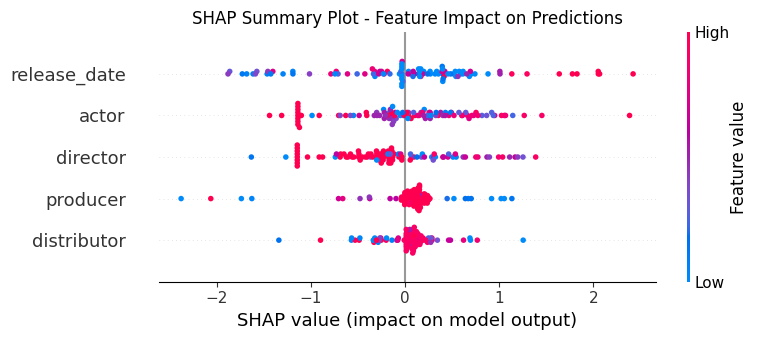

/tmp/ipykernel_29819/2241435474.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names,


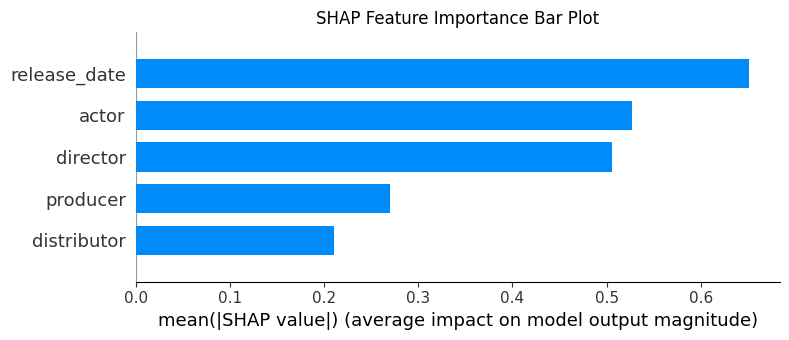


Individual Prediction Explanations:

Sample 1:
  Predicted: drama (Comedy: 0.456, Drama: 0.544)
  Top contributing features:
    distributor: -0.5303 → Drama
    director: -0.3661 → Drama
    release_date: +0.3367 → Comedy
    producer: +0.1557 → Comedy
    actor: +0.0909 → Comedy

Sample 2:
  Predicted: comedy (Comedy: 0.512, Drama: 0.488)
  Top contributing features:
    release_date: -1.6146 → Drama
    actor: +0.9380 → Comedy
    distributor: +0.1575 → Comedy
    director: -0.1487 → Drama
    producer: +0.1295 → Comedy

Sample 3:
  Predicted: comedy (Comedy: 0.639, Drama: 0.361)
  Top contributing features:
    release_date: -1.1918 → Drama
    producer: +0.7032 → Comedy
    director: -0.5612 → Drama
    distributor: -0.4796 → Drama
    actor: +0.4660 → Comedy


In [145]:
# SHAP Analysis

def shap_analysis(model, X_train, X_test, feature_names):
    # SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for test set
    sample_size = min(100, len(X_test))
    X_test_sample = X_test.iloc[:sample_size]
    
    shap_values = explainer.shap_values(X_test_sample)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    print("\nSHAP Results:")
    
    # Feature Importance
    feature_importance = np.abs(shap_values).mean(0)
    shap_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': feature_importance,
        'SHAP_Percentage': (feature_importance / feature_importance.sum()) * 100
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nSHAP Feature Importance:")
    print(shap_importance_df)
    
    # Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    plt.title("SHAP Summary Plot - Feature Impact on Predictions")
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Bar Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                     plot_type="bar", show=False)
    plt.title("SHAP Feature Importance Bar Plot")
    plt.tight_layout()
    plt.show()
    
    # 4. Individual prediction explanation
    print("\nIndividual Prediction Explanations:")
    for i in range(min(3, len(X_test_sample))): # For first 3 samples
        prediction = model.predict(X_test_sample.iloc[i:i+1])[0]
        prediction_proba = model.predict_proba(X_test_sample.iloc[i:i+1])[0]
        
        print(f"\nSample {i+1}:")
        print(f"  Predicted: {prediction} (Comedy: {prediction_proba[0]:.3f}, Drama: {prediction_proba[1]:.3f})")
        
        # Top contributing features
        sample_shap = shap_values[i]
        feature_contributions = list(zip(feature_names, sample_shap))
        feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
        
        print("  Top contributing features:")
        for feat, contrib in feature_contributions[:5]:
            direction = "→ Comedy" if contrib > 0 else "→ Drama"
            print(f"    {feat}: {contrib:+.4f} {direction}")
    
    return shap_values, shap_importance_df

shap_values, shap_importance_df = shap_analysis(model, X_train, X_test, X.columns)

In [147]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text

Training surrogate decision tree...
Surrogate Model Fidelity:
Training: 0.7710
Test: 0.8241

Decision Tree Rules:
|--- release_date <= 144.00
|   |--- director <= 221.00
|   |   |--- release_date <= 1.50
|   |   |   |--- director <= 172.00
|   |   |   |   |--- actor <= 351.50
|   |   |   |   |   |--- class: drama
|   |   |   |   |--- actor >  351.50
|   |   |   |   |   |--- class: drama
|   |   |   |--- director >  172.00
|   |   |   |   |--- director <= 185.50
|   |   |   |   |   |--- class: drama
|   |   |   |   |--- director >  185.50
|   |   |   |   |   |--- class: drama
|   |   |--- release_date >  1.50
|   |   |   |--- release_date <= 45.50
|   |   |   |   |--- class: comedy
|   |   |   |--- release_date >  45.50
|   |   |   |   |--- release_date <= 101.00
|   |   |   |   |   |--- class: drama
|   |   |   |   |--- release_date >  101.00
|   |   |   |   |   |--- class: comedy
|   |--- director >  221.00
|   |   |--- actor <= 411.50
|   |   |   |--- release_date <= 15.50
|   |   | 

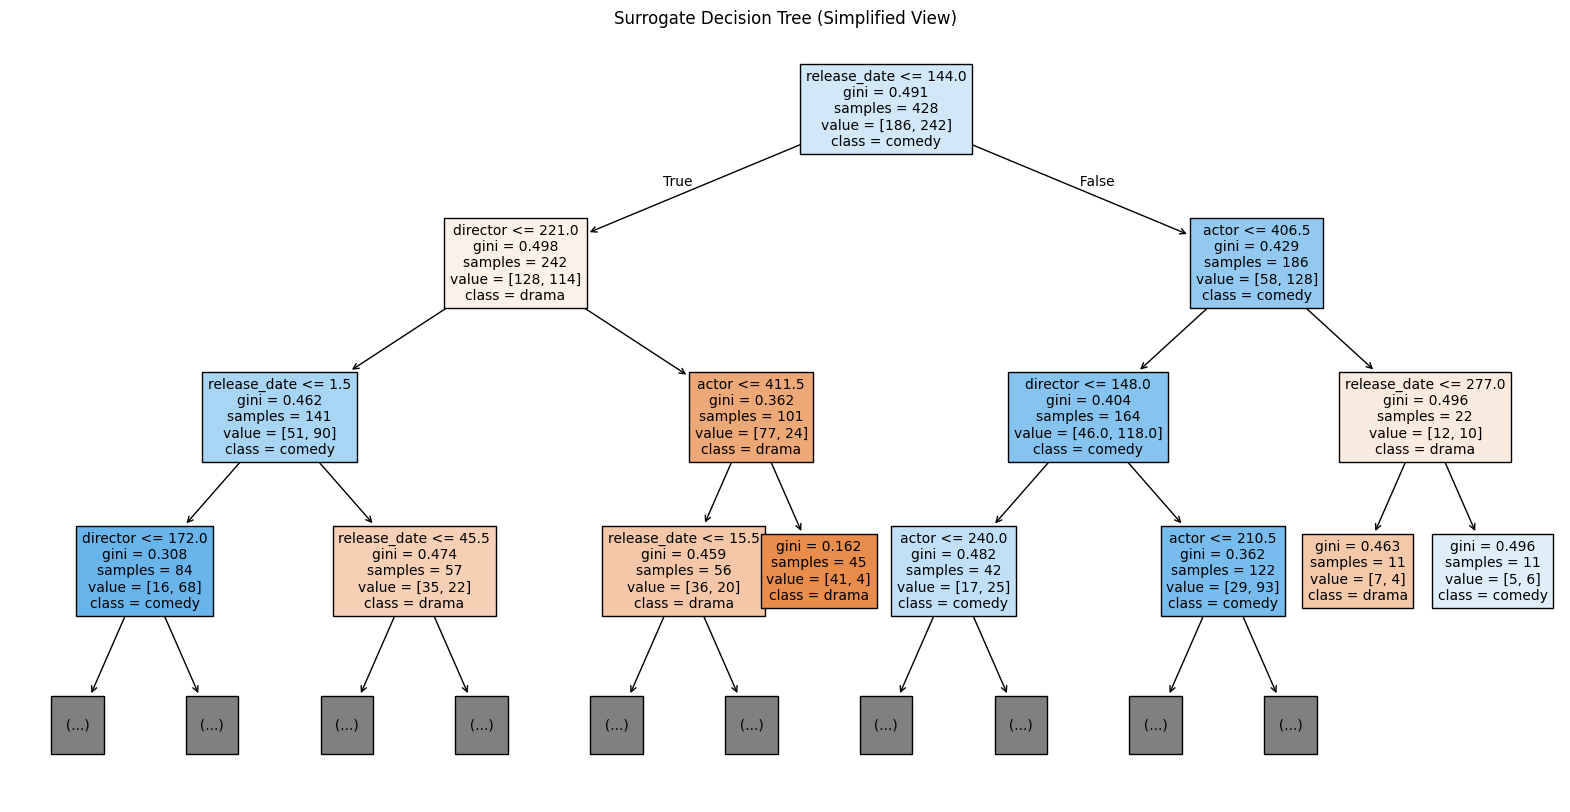

In [150]:
# Decision Tree Surrogate Analysis

def surrogate_tree_analysis(model, X_train, X_test, y_train, y_test, feature_names):
    print("Training surrogate decision tree...")
    
    # Complex model predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Training simple decision tree to mimic complex model
    surrogate_tree = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42
    )
    
    surrogate_tree.fit(X_train, train_predictions)
    
    # Evaluating surrogate model fidelity
    train_fidelity = surrogate_tree.score(X_train, train_predictions)
    test_fidelity = surrogate_tree.score(X_test, test_predictions)
    
    print(f"Surrogate Model Fidelity:")
    print(f"Training: {train_fidelity:.4f}")
    print(f"Test: {test_fidelity:.4f}")
    
    # Extracting interpretable rules
    print(f"\nDecision Tree Rules:")
    tree_rules = export_text(surrogate_tree, feature_names=feature_names, max_depth=4)
    print(tree_rules)
    
    # Feature importance from surrogate
    surrogate_importance = pd.DataFrame({
        'Feature': feature_names,
        'Surrogate_Importance': surrogate_tree.feature_importances_,
        'Percentage': (surrogate_tree.feature_importances_ / surrogate_tree.feature_importances_.sum()) * 100
    }).sort_values('Surrogate_Importance', ascending=False)
    
    print(f"\nSurrogate Tree Feature Importance:")
    print(surrogate_importance)
    
    # Visualizing tree structure
    from sklearn.tree import plot_tree
    plt.figure(figsize=(20, 10))
    plot_tree(surrogate_tree, 
              feature_names=feature_names,
              class_names=['drama', 'comedy'],
              filled=True, 
              max_depth=3,
              fontsize=10)
    plt.title("Surrogate Decision Tree (Simplified View)")
    plt.show()
    
    return surrogate_tree, surrogate_importance

surrogate_tree, surrogate_importance = surrogate_tree_analysis(
    model, X_train, X_test, y_train, y_test, X.columns.tolist()
)

Feature Importance Comparison (Normalized):
                Gini  Permutation    SHAP  Surrogate
actor         0.9047       1.0000  0.8089     0.4775
director      0.6874       0.8103  0.7762     0.7337
distributor   0.3000       0.1379  0.3228     0.0853
producer      0.3427       0.1379  0.4138     0.0000
release_date  1.0000       0.8276  1.0000     1.0000


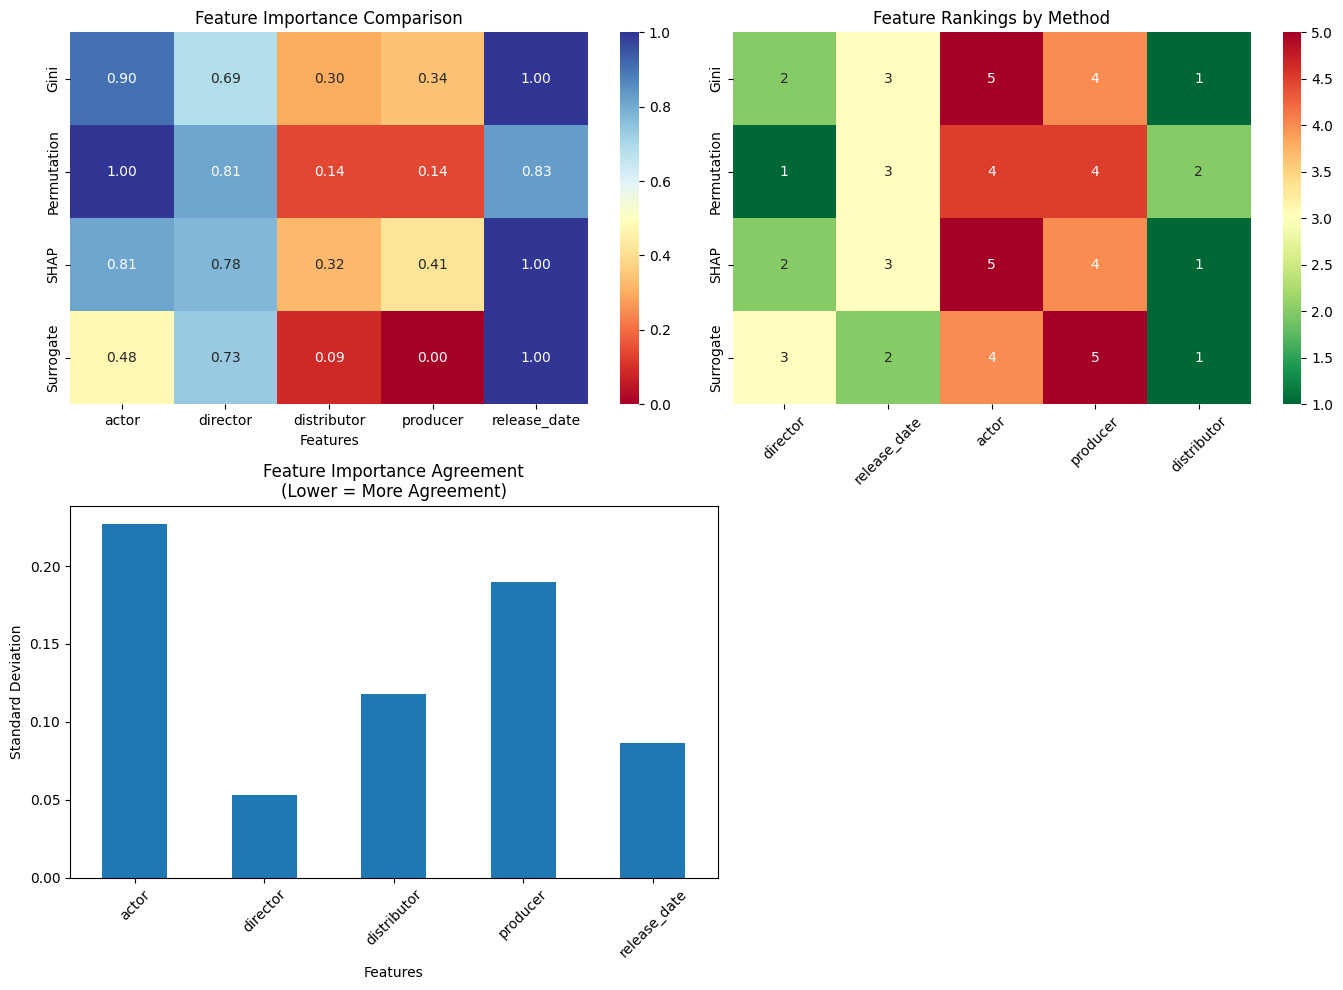


Interpretability Insights:

Most Consistently Important Features:
   director: Avg=0.752, Std=0.053
   release_date: Avg=0.957, Std=0.086
   distributor: Avg=0.212, Std=0.118

Most Disagreed Features:
   actor: Avg=0.798, Std=0.227
   producer: Avg=0.224, Std=0.189


In [157]:
# Comprehensive Interpretability Comparison

def compare_interpretability_methods():
    # Importance scores
    comparison_data = {}
    
    # Gini Importance
    gini_importance = pd.Series(model.feature_importances_, index=X.columns)
    comparison_data['Gini'] = gini_importance
    
    # Permutation Importance
    perm_result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
    perm_importance = pd.Series(perm_result.importances_mean, index=X.columns)
    comparison_data['Permutation'] = perm_importance
    
    # SHAP Importance
    shap_importance = pd.Series(shap_importance_df.set_index('Feature')['SHAP_Importance'])
    comparison_data['SHAP'] = shap_importance
    
    # Surrogate Tree Importance
    surrogate_imp = pd.Series(surrogate_importance.set_index('Feature')['Surrogate_Importance'])
    comparison_data['Surrogate'] = surrogate_imp
    
    # Comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.fillna(0)
    
    # Normalizing for comparison
    comparison_df_norm = comparison_df.div(comparison_df.max())
    
    print("Feature Importance Comparison (Normalized):")
    print(comparison_df_norm.round(4))
    
    # Visualizing comparison
    plt.figure(figsize=(14, 10))
    
    # Heatmap of normalized importances
    plt.subplot(2, 2, 1)
    sns.heatmap(comparison_df_norm.T, annot=True, cmap='RdYlBu', fmt='.2f')
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    
    # Top features by each method
    plt.subplot(2, 2, 2)
    top_features_by_method = {}
    for method in comparison_df_norm.columns:
        top_features_by_method[method] = comparison_df_norm[method].nlargest(5).index.tolist()
    
    # Create ranking comparison
    methods = list(top_features_by_method.keys())
    features = list(X.columns)
    ranking_matrix = np.zeros((len(methods), len(features)))
    
    for i, method in enumerate(methods):
        method_ranking = comparison_df_norm[method].rank(ascending=False)
        ranking_matrix[i] = method_ranking.values
    
    sns.heatmap(ranking_matrix, 
                xticklabels=features, 
                yticklabels=methods,
                cmap='RdYlGn_r', 
                annot=True, 
                fmt='.0f')
    plt.title('Feature Rankings by Method')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    feature_agreement = comparison_df_norm.std(axis=1)
    feature_agreement.plot(kind='bar')
    plt.title('Feature Importance Agreement\n(Lower = More Agreement)')
    plt.xlabel('Features')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print(f"\nInterpretability Insights:")
    
    # Most consistent features
    most_consistent = feature_agreement.nsmallest(3)
    print(f"\nMost Consistently Important Features:")
    for feature, std in most_consistent.items():
        avg_importance = comparison_df_norm.loc[feature].mean()
        print(f"   {feature}: Avg={avg_importance:.3f}, Std={std:.3f}")
    
    # Most disagreed features
    most_disagreed = feature_agreement.nlargest(2)
    print(f"\nMost Disagreed Features:")
    for feature, std in most_disagreed.items():
        avg_importance = comparison_df_norm.loc[feature].mean()
        print(f"   {feature}: Avg={avg_importance:.3f}, Std={std:.3f}")
    
    return comparison_df_norm

# Run comprehensive comparison
comparison_results = compare_interpretability_methods()